### aim: 

### date: 

In [94]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [95]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [96]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### make a better meshmask

Text(0.5, 0.98, 'ocean regions, subdivided, with atlantic mask')

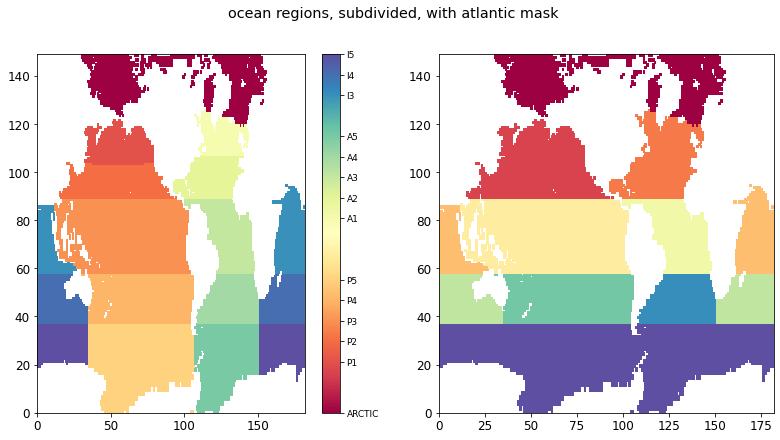

In [97]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

masknoATL = np.copy(maskno)

masknoATL[np.where(masknoATL == 2.6) ]= 5
masknoATL[np.where(masknoATL == 2.4) ]= 5
masknoATL[masknoATL < 5] = 0

masknoFG = np.copy(maskno)

masknoFG[np.where(masknoFG == 0.5)] = 10 #arctic
masknoFG[np.where(masknoFG == 1.2) ]= 20 #Npac
masknoFG[np.where(masknoFG == 1.0) ]= 20 #Npac
masknoFG[np.where(masknoFG == 2.6) ]= 30 #Natl
masknoFG[np.where(masknoFG == 2.4) ]= 30 #Natl
masknoFG[np.where(masknoFG == 3.6) ]= 40 #TropInd
masknoFG[np.where(masknoFG == 1.4) ]= 50 #TropPac
masknoFG[np.where(masknoFG == 2.8) ]= 60 #TropATl
masknoFG[np.where(masknoFG == 3.8) ]= 70 #STropInd
masknoFG[np.where(masknoFG == 1.6) ]= 80 #STropPac
masknoFG[np.where(masknoFG == 3) ]= 90 #STropATl
masknoFG[np.where(masknoFG == 1.8) ]= 100 #SO
masknoFG[np.where(masknoFG == 3.2) ]= 100 #SO
masknoFG[np.where(masknoFG == 4) ]= 100 #So

masknoFG = masknoFG/10

simple_regdict = {'ARCTIC' : {'number' : 1},
            'NorthPac' : {'number': 2},
           'NorthAtl' : {'number': 3},
            'TropInd' : {'number': 4},
           'TropPac' : {'number': 5},
            'TropAtl' : {'number': 6},
           'STropInd' : {'number': 7},
            'STropPac' : {'number': 8},
            'StropAtl' : {'number': 9},
            'SO' : {'number': 10},

          }

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

w = axs[1].pcolor(masknoFG, cmap = tcm, vmin = 1, vmax = 10)
# axs[1].set_xlim([55,150])
# axs[1].set_ylim([75,130])
#cbar = plt.colorbar(w, ticks=tics, ax = axs[0])
#t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided, with atlantic mask')

In [98]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

#TOM12_RW_CO2a, TOM12_RW_ECO4

RW_CO2a_ylist = make_yearlist(1950, 2022, 'diad', 'TOM12_RW_CO2a',\
                              baseDir = '/gpfs/data/greenocean/software/runs/')



In [99]:


def get_ts(regmask, yrst = 1959, yrend = 2022, var = 'Cflx', ttype = 'diad_T', trun = 'TOM12_TJ_RVA0',\
    madein = 'PRONG3/biomes10-builder.ipynb',\
    tunits = 'PgC/yr'):
    
    siy = 60*60*24*365.25
    PgC_mol = 1e-15*12
    
    savenam = f'./data/Regional_{var}_{trun}_{yrst}-{yrend}.nc'
    print(savenam)
    ### make atlantic mask

    
    ##### extract data
    
    yrs = np.arange(yrst,yrend+1,1)
    times = pd.date_range(f"{yrst}/01/01",f"{yrend+1}/01/01",freq='MS',closed='left')
    vals = np.zeros([11,len(times)])
    ind = 0
    for i in range(0,len(yrs)):  
        
        if i%10 == 0:
            print(yrs[i])
        
        rv_diad = xr.open_dataset(make_yearlist(yrs[i],yrs[i],ttype,trun)[0])
        
        regs = ['ARCTIC', 'NorthPac', 'NorthAtl', 'TropInd', 'TropPac',\
                'TropAtl', 'STropInd', 'STropPac', 'STropAtl', 'SO','global']

        simple_regdict = {'ARCTIC' : {'number' : 1},
                    'NorthPac' : {'number': 2},
                   'NorthAtl' : {'number': 3},
                    'TropInd' : {'number': 4},
                   'TropPac' : {'number': 5},
                    'TropAtl' : {'number': 6},
                   'STropInd' : {'number': 7},
                    'STropPac' : {'number': 8},
                    'STropAtl' : {'number': 9},
                    'SO' : {'number': 10},}

        for r in regs:
            if r != 'global':
                
                tno = simple_regdict[r]['number']
                #print(f'{r}, {tno}')
                tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
                tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
                tmesh['csize'] = tmesh['csize'].where(regmask == tno, 0)
                size_reg = np.nansum(tmesh.csize.values)
            
            if r == 'global':

                tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
                tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
                size_reg = np.nansum(tmesh.csize.values)
                tno = 11
            
            if var == 'Cflx':
                tdat = rv_diad[var].weighted(tmesh['csize']).mean(dim = ['x','y'])#.mean(dim = 'time_counter')
                vals[tno-1,ind:ind+12] = tdat.values * size_reg * siy * PgC_mol
        
        ind = ind+12 
#             if var == 'pCO2':
#                 print('ok')
#                 tdat = rv_diad[var].weighted(tmesh['csize']).mean(dim = ['x','y'])#.mean(dim = 'time_counter')
#                 vals[ind:ind+12] = tdat.values


#             if var == 'PPT':
#                 PPT = rv_diad[var].weighted(rv_diad.deptht.isel(deptht=slice(0,17))).mean(dim = ['deptht'])
#                 tdat = PPT.weighted(tmesh['csize']).mean(dim = ['x','y'])
#                 vals[ind:ind+12] = tdat.values

            if var == 'EXP':
                print('ok')
                tdat = rv_diad['EXP'].isel(deptht=10).weighted(tmesh['csize']).mean(dim = ['x','y'])
                vals[ind:ind+12] = tdat.values

               

    data_vars = {var:(['region','time_counter'], vals,
    {'units': tunits,
    'long_name':''}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),
              'region': (['region'], np.arange(1,12,1)),
            }
    # define global attributes
    attrs = {'made in':madein,
    'desc': 'see notebook where made for region definitions'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)  
        


In [127]:
extract = False
if extract:
    var = 'Cflx'; ttype = 'diad_T'; yrst = 1920; yrend = 2022; 
#     get_ts(masknoFG, yrst = yrst, yrend = yrend, \
#            var = var, ttype = ttype, trun = 'TOM12_RW_CO2a')#,
#     get_ts(masknoFG, yrst = yrst, yrend = yrend, \
#            var = var, ttype = ttype, trun = 'TOM12_RW_ECO4')
    yrst = 1948; yrend = 2100; 
    get_ts(masknoFG, yrst = yrst, yrend = yrend, \
           var = var, ttype = ttype, trun = 'TOM12_TJ_CA02')#,
    get_ts(masknoFG, yrst = yrst, yrend = yrend, \
           var = var, ttype = ttype, trun = 'TOM12_TJ_EA02')
#     yrend = 2022; 
#     get_ts(masknoFG, yrst = yrst, yrend = yrend, \
#            var = var, ttype = ttype, trun = 'TOM12_TJ_RVA0')

In [129]:
ml = {'TOM12_TJ_CA02' : {'name' : 'TJ_CA02', 
                        'desc' : 'CO2 UKESM',
                       'color' : 'red',
                         'linestyle' : ':',
                      },
      'TOM12_RW_CO2a' : {'name' : 'RW_CO2a', 
                        'desc' : 'CO2 ERA5',
                       'color' : 'red',
                         'linestyle' : '-',
                      },
      
      'TOM12_TJ_EA02' : {'name' : 'TJ_EA02', 
                        'desc' : 'ECO UKESM',
                       'color' : 'blue',
                         'linestyle' : ':',
                      },
      'TOM12_RW_ECO4' : {'name' : 'RW_ECO4', 
                        'desc' : 'ECO ERA5',
                       'color' : 'blue',
                         'linestyle' : '-',
                      },
      
        'TOM12_TJ_RVA0' : {'name' : 'TJ_RVA0', 
                'desc' : 'GCB2023 ERA',
               'color' : 'y',
                 'linestyle' : '-',
              },
      
          }

ml['TOM12_TJ_CA02']['name']

'TJ_CA02'

In [130]:
Cflx_RW_CO2a = xr.open_dataset('./data/Regional_Cflx_TOM12_RW_CO2a_1920-2022.nc')
Cflx_RW_ECO4 = xr.open_dataset('./data/Regional_Cflx_TOM12_RW_ECO4_1920-2022.nc')
Cflx_TJ_CA02 = xr.open_dataset('./data/Regional_Cflx_TOM12_TJ_CA02_1948-2100.nc')
Cflx_TJ_EA02 = xr.open_dataset('./data/Regional_Cflx_TOM12_TJ_EA02_1948-2100.nc')
Cflx_TJ_RVA0 = xr.open_dataset('./data/Regional_Cflx_TOM12_TJ_RVA0_1948-2022.nc')

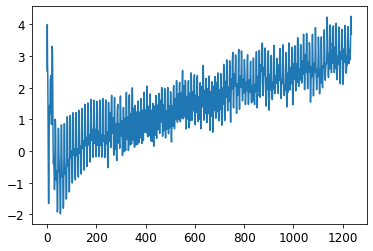

In [131]:
plt.plot(Cflx_RW_CO2a.Cflx[10,:])

RW_CO2a (CO2 ERA5)
RW_ECO4 (ECO ERA5)
TJ_CA02 (CO2 UKESM)
TJ_EA02 (ECO UKESM)
TJ_RVA0 (GCB2023 ERA)


Text(0.5, 0.98, 'seasonal climatologies in Cflx (PgC/year) (2010-2019)')

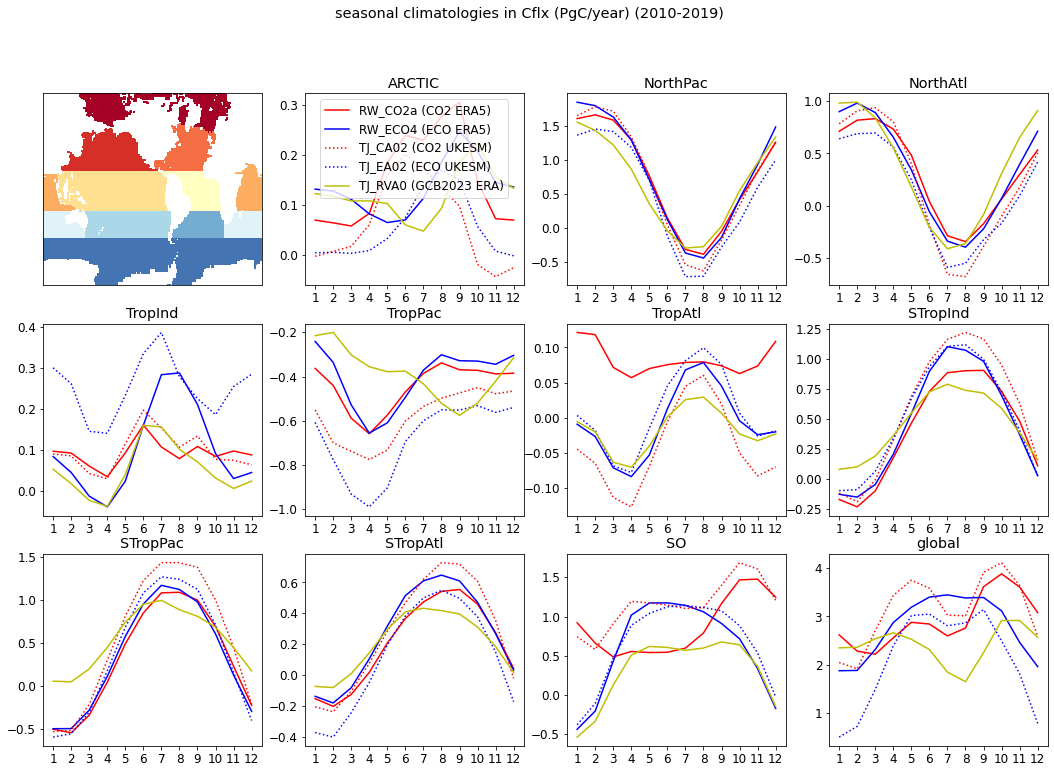

In [133]:

tvar = 'Cflx'


dslist = [Cflx_RW_CO2a, Cflx_RW_ECO4,\
          Cflx_TJ_CA02, Cflx_TJ_EA02, Cflx_TJ_RVA0]; 
titlist = ['TOM12_RW_CO2a', 'TOM12_RW_ECO4',\
          'TOM12_TJ_CA02', 'TOM12_TJ_EA02', 'TOM12_TJ_RVA0']; 

regind = [1,2,3,4,5,6,7,8,9,10,11]
axind = [1,2,3,4,5,6,7,8,9,10,11]

regs = ['ARCTIC', 'NorthPac', 'NorthAtl', 'TropInd', 'TropPac',\
            'TropAtl', 'STropInd', 'STropPac', 'STropAtl', 'SO', 'global']

fact = 1.5
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

dind = 0
for tds in dslist:
    
    trun = titlist[dind]
    tnam = ml[trun]['name']
    tdesc = ml[trun]['desc']
    tcol =  ml[trun]['color']
    tlin =  ml[trun]['linestyle']
    moddesc = f'{tnam} ({tdesc})'
    print(moddesc)
    for i in range(0,11):

        treg = regind[i]
        tax = axind[i]

        tdat = tds[tvar].where(tds['region'] == treg, drop=True).\
        sel(time_counter = slice('2010-01-01','2019-12-01'))

        axs[tax].plot(np.arange(1,13,1), tdat[0,:].groupby('time_counter.month').mean(),\
                      label = f'{moddesc}', color = tcol, linestyle = tlin)
    dind = dind+1
for i in range(0,11):
    
    #tax = axind[i]
    axs[i+1].set_xticks(np.arange(1,13,1))
    axs[i+1].set_xticks(np.arange(1,13,1))
    axs[i+1].set_title(regs[i])
    
w = axs[0].pcolor(masknoFG, cmap = 'RdYlBu', vmin = 1, vmax = 11)
    
axs[1].legend()
axs[0].set_xticks([]); axs[0].set_yticks([])

plt.suptitle('seasonal climatologies in Cflx (PgC/year) (2010-2019)')

RW_CO2a (CO2 ERA5)
RW_ECO4 (ECO ERA5)
TJ_CA02 (CO2 UKESM)
TJ_EA02 (ECO UKESM)
TJ_RVA0 (GCB2023 ERA)


Text(0.5, 0.98, 'seasonal climatologies in Cflx (PgC/year) (2010-2019)')

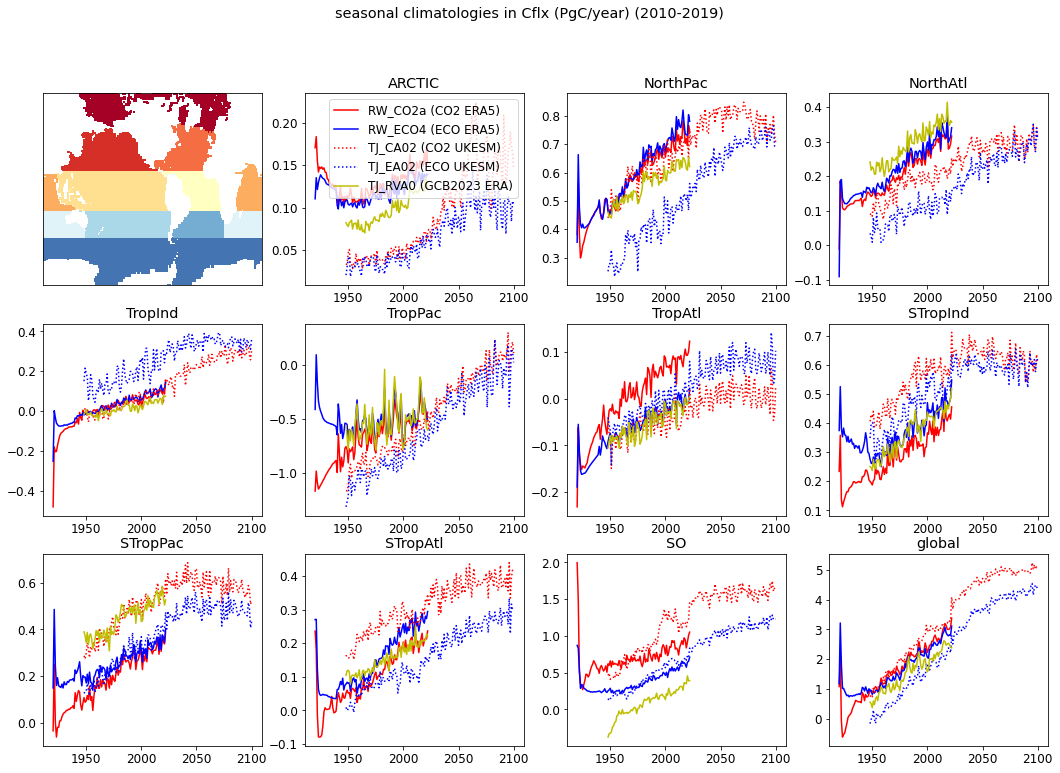

In [134]:

tvar = 'Cflx'

dslist = [Cflx_RW_CO2a, Cflx_RW_ECO4,\
          Cflx_TJ_CA02, Cflx_TJ_EA02, Cflx_TJ_RVA0]; 
titlist = ['TOM12_RW_CO2a', 'TOM12_RW_ECO4',\
          'TOM12_TJ_CA02', 'TOM12_TJ_EA02', 'TOM12_TJ_RVA0']; 

regind = [1,2,3,4,5,6,7,8,9,10,11]
axind = [1,2,3,4,5,6,7,8,9,10,11]

regs = ['ARCTIC', 'NorthPac', 'NorthAtl', 'TropInd', 'TropPac',\
            'TropAtl', 'STropInd', 'STropPac', 'STropAtl', 'SO', 'global']

fact = 1.5
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

dind = 0
for tds in dslist:
    
    trun = titlist[dind]
    tnam = ml[trun]['name']
    tdesc = ml[trun]['desc']
    tcol =  ml[trun]['color']
    tlin =  ml[trun]['linestyle']
    moddesc = f'{tnam} ({tdesc})'
    print(moddesc)
    for i in range(0,11):

        treg = regind[i]
        tax = axind[i]

        tdat = tds[tvar].where(tds['region'] == treg, drop=True).groupby('time_counter.year').mean()

        
        axs[tax].plot(tdat.year, tdat[0,:],\
                      label = f'{moddesc}', color = tcol, linestyle = tlin)
    dind = dind+1
for i in range(0,11):
    
    #tax = axind[i]
#     axs[i+1].set_xticks(np.arange(1,13,1))
#     axs[i+1].set_xticks(np.arange(1,13,1))
    axs[i+1].set_title(regs[i])
    
w = axs[0].pcolor(masknoFG, cmap = 'RdYlBu', vmin = 1, vmax = 11)
    
axs[1].legend()
axs[0].set_xticks([]); axs[0].set_yticks([])

plt.suptitle('seasonal climatologies in Cflx (PgC/year) (2010-2019)')

## primary productivity

In [135]:
RW_CO2a_ylist = make_yearlist(1950, 2022, 'diad', 'TOM12_RW_CO2a',\
                              baseDir = '/gpfs/data/greenocean/software/runs/')

In [146]:
t = xr.open_dataset(RW_CO2a_ylist[0])


tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize_broad = np.zeros([31,149,182])

regmask_broad = np.zeros([31,149,182])

for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
    regmask_broad[i,:,:] = masknoFG
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

<xarray.DataArray 'PPT' (time_counter: 12, deptht: 31, y: 149, x: 182)>
[10087896 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 -78.19 -78.19 -78.19 -78.19 ... 0.0 0.0 0.0
    nav_lon        (y, x) float32 78.0 80.0 82.0 84.0 86.0 ... 0.0 0.0 0.0 0.0
  * deptht         (deptht) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    time_centered  (time_counter) object 1950-01-16 12:00:00 ... 1950-12-16 1...
  * time_counter   (time_counter) object 1950-01-16 12:00:00 ... 1950-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           P+D PrimProd
    units:               molC/m3/s
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)

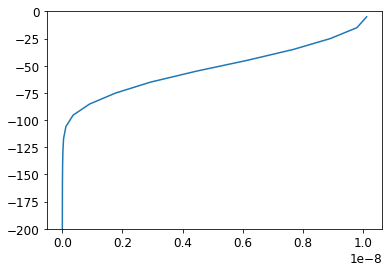

In [144]:
plt.plot(t.PPT[0,:,70,50],-t.deptht)
plt.ylim([-200,0])

t.PPT